Import des différentes librairies

In [2]:
import tweepy
import squarify
from geopy.geocoders import Nominatim
import folium
import json_lines
import json
import time
import datetime
import random
import itertools
import os
import matplotlib.pyplot as plt
from texttable import Texttable
import jsonpickle

In [3]:
tweetsPerQry = 100  # this is the max the API permits

searchQuery = '#trump'  # this is what we're searching for
maxTweets = 1000 # Some arbitrary large number

language = "en"                                          # Language, must be ISO 639-1 code
#since = None                                             # Start date
#until = datetime.datetime.now().strftime("%Y-%m-%d")     # End date
#until = "2016-01-01"     # End date
result_type = "mixed"                                  # recent, popular, or mixed
geocode = None                                         # Geocode
tweet_mode='extended'

Configuration du nom du fichier utilisé

In [4]:
%env TIME={time.time()}
%env OUTPUT_TWEET_FILENAME=output_tweet_{os.environ['TIME']}.json
%env TWEET_JSON_FILENAME=input_tweet_{os.environ['TIME']}.json


env: TIME=1521714372.9915159
env: OUTPUT_TWEET_FILENAME=output_tweet_1521714372.9915159.json
env: TWEET_JSON_FILENAME=input_tweet_1521714372.9915159.json


In [6]:
with_geo=False
API_key = json.load(open("API_key.txt", "r"))

auth = tweepy.OAuthHandler(API_key["consumer_key"], API_key["consumer_secret"])
auth.set_access_token(API_key["access_token"], API_key["access_token_secret"])
api = tweepy.API(auth)

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))

filename = "tweets-database/"+os.environ['TWEET_JSON_FILENAME']
with open(filename, 'w') as f:
   while tweetCount < maxTweets:
       try:
           if (max_id <= 0):
               if (not sinceId):
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang=language, tweet_mode=tweet_mode)
               else:
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                           since_id=sinceId, lang=language, tweet_mode=tweet_mode)
           else:
               if (not sinceId):
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                           max_id=str(max_id - 1), lang=language, tweet_mode=tweet_mode)
               else:
                   new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                           max_id=str(max_id - 1),
                                           since_id=sinceId,
                                           lang=language, tweet_mode=tweet_mode)
           if not new_tweets:
               print("No more tweets found")
               break
           for tweet in new_tweets:
               f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                       '\n')
           tweetCount += len(new_tweets)
           print("Downloaded {0} tweets".format(tweetCount))
           max_id = new_tweets[-1].id
       except tweepy.TweepError as e:
           # Just exit if any error
           print("some error : " + str(e))
           break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, filename))

#tweets = api.search(q=keyword,  
#                    lang=language, 
#                    geocode=geocode,
#                    count=count_tweets,
#                    result_type=result_type,
                   
#                   )

#tweets = api.search( q=keyword,tweet_mode='extended',include_rts=False,count=2000)

#json_tweets=[]
#for tweet in tweets:
#    json_tweets.append(json.dumps(tweet._json))

#json_str = "\n".join(json_tweets)

#filename = "tweets-database/"+os.environ['TWEET_JSON_FILENAME']
#with open(filename, "w") as f:
#    f.write(json_str)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 499 tweets
Downloaded 597 tweets
Downloaded 689 tweets
Downloaded 775 tweets
Downloaded 870 tweets
Downloaded 964 tweets
Downloaded 1064 tweets
Downloaded 1064 tweets, Saved to tweets-database/input_tweet_1521714372.9915159.json


Envoie des tweets collectés sur le datacenter et lancement de l'analyse

In [7]:
%%bash
cp tweets-database/$TWEET_JSON_FILENAME Algo1/$TWEET_JSON_FILENAME
cd Algo1
sbt "put $TWEET_JSON_FILENAME"
rm -rf $TWEET_JSON_FILENAME
sbt "submit $TWEET_JSON_FILENAME"
sbt "getOutput 'defaultoutput.json'"
cp defaultoutput.json ../tweets-database/$OUTPUT_TWEET_FILENAME
rm -rf defaultoutput.json

[info] Loading settings from idea.sbt ...
[info] Loading global plugins from /Users/Frego/.sbt/1.0/plugins
[info] Loading settings from plugins.sbt ...
[info] Loading project definition from /Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/project
[info] Loading settings from build.sbt ...
[info] Set current project to SparkSenti (in build file:/Users/Frego/Documents/Centrale/4A/OPTION/08_Projet/SparkSenti/Algo1/)
spawn scp input_tweet_1521714372.9915159.json fregosi1@sparksenti:.
fregosi1@sparksenti's password: 
input_tweet_1521714372.9915159.json           100% 6837KB  14.1MB/s   00:00    
spawn ssh fregosi1@sparksenti
fregosi1@sparksenti's password: 

Welcome to Bright release         7.3

                                                        Based on CentOS Linux 7
                                                                    ID: #000002

Use the following commands to adjust your environment:

'module avail'            - show available modules
'module ad

Pour test de viz (evite de lancer le workflow complet)

In [8]:
#%env OUTPUT_TWEET_FILENAME=output_test.json
#%env TWEET_JSON_FILENAME=input_test.json

In [9]:
file_json = open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'],"r", encoding="utf8");
reader = json_lines.reader(file_json)


In [10]:
file_json = open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'],"r", encoding="utf8");
reader = json_lines.reader(file_json)
reader = list(reader)
geolocator = Nominatim(timeout=10)

WASH_COORD = [38.8949549, -77.0366456]
LYON_COORD = [45.750000,4.850000]
US_COORD = [39,-95]

# Build map 
map_main = folium.Map(location=[45,0],
                      zoom_start=1, 
                      tiles='cartodbpositron', 
                      width=640, 
                      height=400)

  

#for tweet in itertools.islice(reader, 10):     #  ======> sert à limiter le nombre de tweets afficher sur la carte
for tweet in reader:       # =======> sert à afficher tout les tweets
    location_json = tweet['tweet']['user']['location']
    #print("location_json : {0}".format(location_json)) #affichage pour debug
    if (location_json!= ''):
        location = geolocator.geocode(location_json)
        #print("location : {0}".format(location))
        if location != None:
            if tweet['tweet']['user']['url']!=None:
                popup_image ='''<a href="'''+ tweet['tweet']['user']['url'] +'''"><img src="''' + tweet['tweet']['user']['profile_image_url'] + '''" alt="pic " /></a>'''
            else:
                popup_image ='''<img src="''' + tweet['tweet']['user']['profile_image_url'] + '''" alt="pic " />'''
            popup_text = '<b>'+tweet['tweet']['user']['name'].replace("'", r'\"')+'</b>' \
            + ' tweeted : '+ '<i>' + tweet['tweet']['full_text'].replace("'", r'\"') + '</i>'
            popup = '<center>' + popup_image + '<br\><br\>' + popup_text + '</center>'
            location_lat_long = [location.latitude + random.gauss(0,0000.1), location.longitude + random.gauss(0,000.1)]
            if tweet['result'] == 'Positif':
                folium.Marker(location_lat_long,                               
                          popup= popup,
                          icon=folium.Icon(color='green')
                         ).add_to(map_main)
            elif tweet['result'] == 'Negatif':
                    folium.Marker(location_lat_long,   
                              popup= popup,
                              icon=folium.Icon(color='red')
                             ).add_to(map_main)   
            elif tweet['result'] == 'Neutre':
                folium.Marker(location_lat_long,   
                              popup= popup,
                              icon=folium.Icon(color='lightgray')
                             ).add_to(map_main)                    




# Display map in Jupyter
map_main

GeocoderServiceError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:749)

Treemap chart

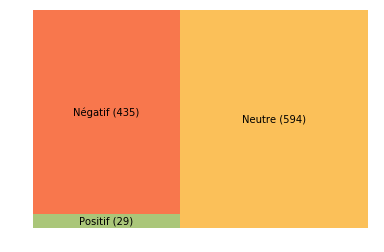

In [11]:
y=[0,0,0];
with open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'], 'rb') as f:
    for tweet in json_lines.reader(f):
        if tweet['result'] == 'Positif':
            y[0]+=1
        elif tweet['result'] == 'Negatif':
            y[1]+=1
        elif tweet['result'] == 'Neutre':
            y[2]+=1
            
x = ["Positif", "Négatif", "Neutre"];
x = [x[i] + " (" + str(y[i]) + ")" for i in range(3)]

colors=["#87AF41","#F63E02","#FAA613"];
if 0 in y:
    k=y.index(0)
    del x[k]
    del y[k]
    del colors[k]
    
squarify.plot(sizes=y, label=x, alpha=.7 ,color=colors)
plt.axis('off')
plt.show()

Liste des tweets

In [12]:
data=[["Score","Tweet"]]
with open("tweets-database/"+os.environ['OUTPUT_TWEET_FILENAME'], 'rb') as f:
    for tweet in json_lines.reader(f):
        data.append([tweet["result"],tweet["tweet"]["full_text"]])
t = Texttable()
t.add_rows(data)
print (t.draw())

+---------+--------------------------------------------------------------------+
|  Score  |                               Tweet                                |
+=========+====================================================================+
| Neutre  | RT @pollsofpolitics: In your opinion should @realDonaldTrump FIRE  |
|         | #Mueller??                                                         |
|         | Vote and retweet to spread poll!! #TheResistance #Trump #Resis…    |
+---------+--------------------------------------------------------------------+
| Neutre  | RT @Trumpfan1995: What should happen to the Russia probe led by    |
|         | Robert Mueller? Do vote and retweet. #MAGA #Trump                  |
+---------+--------------------------------------------------------------------+
| Neutre  | RT @Trumpfan1995: What should happen to the Russia probe led by    |
|         | Robert Mueller? Do vote and retweet. #MAGA #Trump                  |
+---------+-----------------